In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin

# Load Data

In [6]:
data_path = 'C:/Users/ticom/VLabs/Data'
df = pd.read_csv(data_path+'/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
# df = pd.read_csv('https://raw.githubusercontent.com/marcos-mansur/vlabs-challenge/main/Data/sales_20_21_train.csv', header=0, parse_dates=['DT_VENDA'])
df_sub = pd.read_csv(data_path+'/sample_submission.csv',header=0)

# Functions

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate plot: learning curve

    """
    if axes is None:
        _, axes = plt.subplots(1, figsize=(20, 10))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='neg_root_mean_squared_error',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    # intervalos de spread 
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    # curvas
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt

In [3]:
def split_per_dates(df,train_start,target_start, sub_start):
    # target do treinamento
    df_target = df[df.DT_VENDA > target_start]
    y_train = df_target.groupby('ID_CLIENTE')['VALOR'].sum()
    # dados de treinamento
    df_train = df[(df['DT_VENDA']>train_start) & (df['DT_VENDA']<target_start)].copy()
    # dados para previsão
    df_test = df[df['DT_VENDA']>sub_start]
    return df_train, y_train, df_test

# Estratégia

In [7]:
# intervalo de 90 dias
delta90 = pd.to_timedelta(90,unit='d')
# data mais recente do dataset
max_date = df['DT_VENDA'].max()
# data de início do target
target_start = max_date - delta90
# data de início dos dados de treino
train_start = target_start - 2*delta90
# data de início dos dados de previsão (submissão)
sub_start = max_date - 2*delta90

# Preprocessing

A função abaixo recebe o df cru e retorna o df final do modelo. Feature engineer e outras mudanças devem ser feitas preferencialmente aqui porque ao fim dessa transformação perdemos os dados abertor por compra.

In [39]:
class treated_data(BaseEstimator,TransformerMixin):
    " transformador que cria colunas com o paramâmetro de inicialização igual a 'True' "
    def __init__(self, 
                 Frequency:bool=True, 
                 Recency:bool=True, 
                 valor_3m:bool=True, 
                 media:bool=True,
                 mediana:bool=True,
                 std:bool=True,
                 periodo:bool=False):
        super().__init__()
        self.Frequency=Frequency, 
        self.Recency= Recency, 
        self.valor_3m=valor_3m, 
        self.media=media,
        self.mediana = mediana,
        self.std = std
        self.periodo = periodo
        pass
    
    def fit(self, df_pp:pd.DataFrame, y=None):
        return self
    
    def transform(self, df_pp:pd.DataFrame, y=None):
        max_date = df_pp['DT_VENDA'].max()

        #agrupar por cliente somando o valor
        cust_revenue = df_pp.groupby(['ID_CLIENTE'])['VALOR'].sum().copy()
        # transformar em df
        cust_rev = pd.DataFrame(cust_revenue)
        if self.Frequency:
            # feature com número de compras feitas no período de teste
            cust_rev['Frequency'] = df_pp.groupby(['ID_CLIENTE'])['ID_VENDA'].count()

        # diferença entre a data da primeira e ultima compra
        #cust_rev['periodo_compras'] = df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max() - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].min()
        #cust_rev['periodo_compras'] = cust_rev['periodo_compras'].apply(lambda x: x.days)
        
        if self.media:
            # media entre os valores das compras de cada cliente
            cust_rev['valor medio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].mean()
        if self.mediana:
            cust_rev['valor mediana'] = df_pp.groupby('ID_CLIENTE')['VALOR'].median()
        if self.std:
            cust_rev['valor desvio'] = df_pp.groupby('ID_CLIENTE')['VALOR'].std()

        if self.Recency:
            # data da ultima compra
            cust_rev['Recency'] = max_date - df_pp.groupby(['ID_CLIENTE'])['DT_VENDA'].max()
            cust_rev['Recency'] = cust_rev['Recency'].apply(lambda x: x.days)
        if self.valor_3m: 
            # soma do VALOR dos ultimos 3 meses de cada cliente
            cust_rev['valor_3m'] = df_pp[
                    df_pp['DT_VENDA']>(df_pp['DT_VENDA'].max() - delta90)].groupby(['ID_CLIENTE'])['VALOR'].sum()

        return cust_rev.fillna(0)

In [57]:
def transform_df(df):
    df = df.copy()
    # divide os dados de treino e previsão pela data
    df_train, target_train, df_test = split_per_dates(df,train_start,target_start,sub_start)
    # modifica o df e cria features nos dados de treino
    df_train1 = treated_data().fit_transform(df_train)
    # para alinhar o index do target do treino com os dados de treino
    df_train2 = df_train1.join(other=target_train, on='ID_CLIENTE', lsuffix='_sum', rsuffix='_TARGET')
    x_train = df_train2.drop('VALOR_TARGET',axis=1)
    y_train = df_train2.VALOR_TARGET.fillna(0)
    # modifica o df e cria features nos dados de test
    x_test = treated_data().fit_transform(df_test)
    return x_train, y_train, x_test

In [58]:
x_train_total, y_train_total, x_test = transform_df(df)

In [60]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train_total, 
                                                                            y_train_total, 
                                                                            random_state=0,
                                                                            test_size=0.3)

# Model

In [61]:
en = ElasticNet(random_state=0)
en.fit(x_train_split, y_train_split)
en_pred = en.predict(x_test_split)

In [62]:
# validação direta
score_dir = mean_squared_error(y_test_split,en_pred, squared=False)
score_dir

262.30383832708014

In [63]:
# validação cruzada
score = cross_val_score(en, X=x_train_total, y=y_train_total, cv=5, scoring='neg_root_mean_squared_error')
print('score: ',-score.mean(), '\nstd = :', score.std())

score:  263.60348537296477 
std = : 19.346947106298106


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

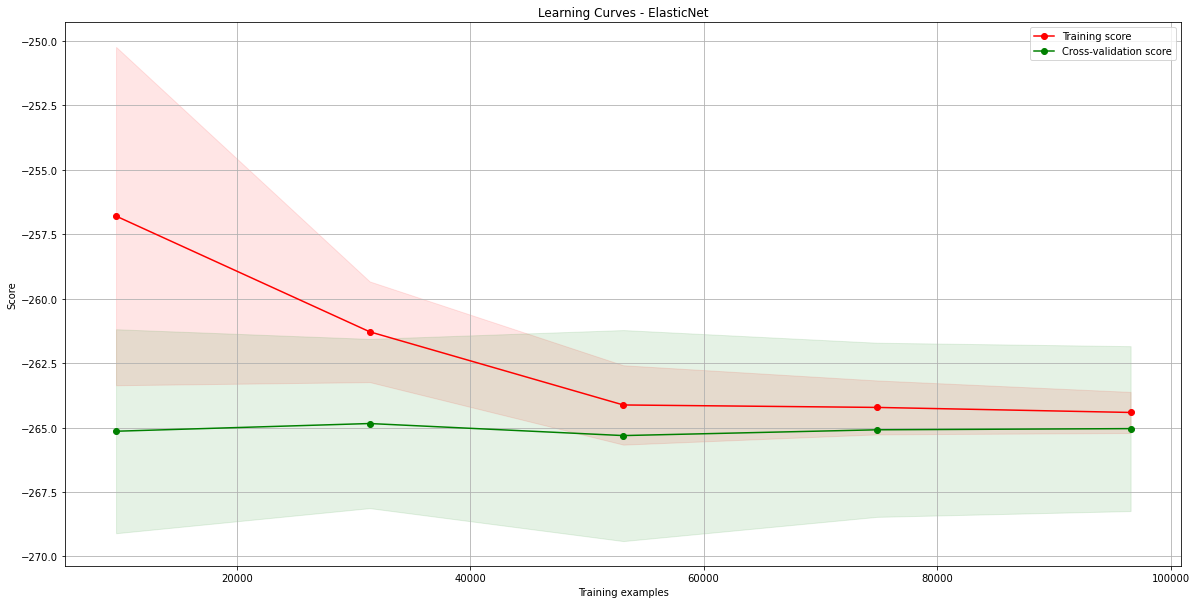

In [29]:
en_lc = ElasticNet(random_state=0)
title = "Learning Curves - ElasticNet"
plot_learning_curve(en_lc, title, x_train_split, y_train_split, cv=5, n_jobs=-1)

Não aparenta overfitting

<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

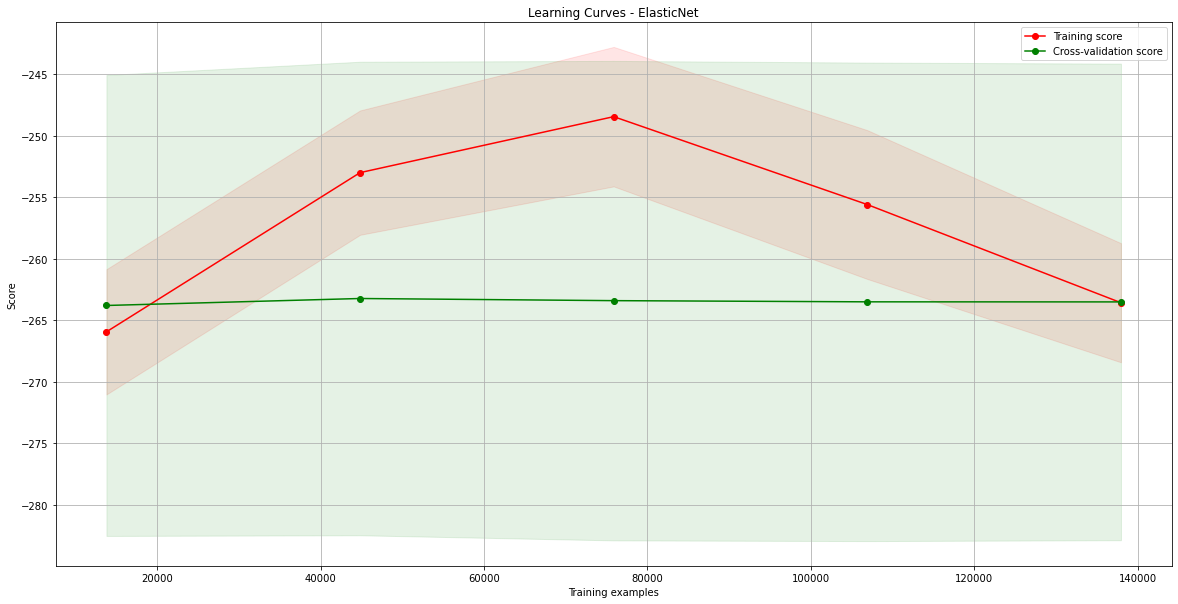

In [33]:
en_lc = ElasticNet(random_state=0)
title = "Learning Curves - ElasticNet"
plot_learning_curve(en_lc, title, x_train_total, y_train_total, cv=5, n_jobs=-1)

Não sei o que ta acontecendo aqui kkkkkkkk

# Submission

In [14]:
en = ElasticNet(random_state=0)
en.fit(x_train_total, y_train_total)
en_pred = en.predict(df2_test)

en_pred_df = pd.DataFrame(en_pred, index=df2_test.index).reset_index()
en_pred_df.columns = ['ID_CLIENTE', 'VALOR']
sub5 = pd.DataFrame(df_sub['ID_CLIENTE']).set_index('ID_CLIENTE').join(en_pred_df.set_index('ID_CLIENTE'),
                                           on='ID_CLIENTE')
#sub5.reset_index().fillna(0).to_csv('C:/Users/ticom/VLabs/Submissions/sub5.csv', index=False)

In [20]:
sub5

,VALOR
ID_CLIENTE,
4,471.272490
9,77.601815
12,278.050066
15,157.540902
19,55.723262
...,...
384409,67.292199
384411,159.056544
384415,42.367053
